# Predicting tourism spending of Tanzania using survey data

**Link to github repository with raw data:** https://github.com/christopherkindl/predicting-tourism-spending-in-Tanzania

## Table of contents

* [0. Setup of environment and import of dependencies](##0.-Setup-of-environment-and-import-of-dependencies)
* [1. Introduction](##1.-Introduction)
* [2. Data cleaning](##2.-Data-cleaning)
* [3. Data exploration](##3.-Data-exploration)
* [4. Data preperation for model training](##4.-Data-preperation-for-model-training)
* [5. Model selection and training](##5.-Model-selection-and-training)
* [6. Conclusion](##6.-Conclusion)

**word count:** approx. 1935 words

## 0. Setup of environment and import of dependencies

In [446]:
# autosave every 60 seconds
%autosave 60

#display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#import standard libraries
import numpy as np
import pandas as pd
import os


#make this notebook's output stable across runs
np.random.seed(42)
    
#ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

#preprocessing libraries
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#model libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

#evaluation libraries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.base import clone

#store model
import pickle

Autosaving every 60 seconds


## 1. Introduction

**Source of data**

The dataset was published as part of a hackathon provided by the platform `zindi.africa`. It is based on real-life data that was collected by the National Bureau of Statistics (NBS) in Tanzania. Since the dataset was issued in `early 2020`, it can be considered as up-to-date information of Tanzania's tourism industry.

Submissions from other participants for this hackathon challenge are not visible and accessible.

Link to the data source: https://zindi.africa/competitions/tanzania-tourism-prediction/data

**Goal**

The goal of this notebook is to predict the tourism spending based on the data provided by the NBS in Tanzania.

## 2. Data cleaning

**Loading data**

The dataset is already split into a train and test dataset. However, since the test dataset does not include the response variable `total expenditure`, it cannot be used for measuring prediction accuracy. However, the train dataset still consists of more than `4,000 records`. Consequently, the test data will be neglected and we treat the train dataset as a complete dataset.

In [441]:
data_path = os.path.join(project_root_dir, '00_data')

raw_data = 'Train.csv'
raw_variable_explanations = 'VariableDefinitions.csv'

def load_data(data_path, data_type):
    csv_path = os.path.join(data_path, data_type)
    return pd.read_csv(csv_path)

In [442]:
data = load_data(data_path, raw_data)
variable_explanations = load_data(data_path, raw_variable_explanations)
#data.head(5)
#variable_explanations.head(25)

**Validate column data types and missing values**

Next, we identify missing values and validate the column data types. Since we only want to calculate with numerical data, we convert all categorical columns into numerical ones.

In [443]:
#identify number of columnes with missing value
incomplete_columns = data.isna().any(axis=0).sum()
print("Number of incomplete columns: %d" % incomplete_columns)

#identify number of rows with missing values
incomplete_rows = data[data.isna().any(axis=1)]
print("Number of incomplete rows: %d" % len(incomplete_rows))

print('------------------------')

#get general overview of column types and number of non-null values
data.info()

Number of incomplete columns: 4
Number of incomplete rows: 1349
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_t

- **missing values in travel_with**: The number of rows seems to be high. One reason could be that these participants have assumed leaving this field empty would indicate that they did not travel with someone else (even though the answer label `alone` is provided by the questionnaire). We replace empty values in this column with a new category, `None`.


- **missing values in total_female and total_male**: Since the number of missing values in these two columns is really small, we drop the corresponding rows.


- **missing values in most_impressing**: We replace empty values in this column with a new category, `None`, assuming that participants did not find anything impressing.


- **total_cost**: the money amounts in `total_cost` are expressed in Tanzania's local currency, TZS. The highly inflated currency is not only an economic problem, it can also be very challenging to interpret data analyses at this unusual magnitude. This is why we convert it to US-Dollar using the current day course.

In [444]:
#drop column 'ID' since the sequence is not correct anymore as it got already published as a train dataset
data.drop(columns=['ID'], inplace = True)

#drop rows with missing values in column total_female and total_male
data.dropna(subset=['total_male', 'total_female'], inplace = True)

#for empty rows in travel_with and most_impressing columns, fill in with another category, None
data.travel_with.fillna('None',inplace=True)
data.most_impressing.fillna('None',inplace=True)

#change currency to US-Dollar in column total_cost and round to zero decimals
exchange_rate = 2293 #22293  TZS/US-Dollar at 1st January 2020, using exchange rate from same period (early 2020) the data was published
data['total_cost'] = data['total_cost'] / exchange_rate
data['total_cost'].round(0)

#revalidate dataset
data.info()

0        294.0
1       1402.0
2       1446.0
3       3397.0
4        723.0
         ...  
4804    1446.0
4805    4662.0
4806     980.0
4807     506.0
4808    5783.0
Name: total_cost, Length: 4801, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4801 entries, 0 to 4808
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                4801 non-null   object 
 1   age_group              4801 non-null   object 
 2   travel_with            4801 non-null   object 
 3   total_female           4801 non-null   float64
 4   total_male             4801 non-null   float64
 5   purpose                4801 non-null   object 
 6   main_activity          4801 non-null   object 
 7   info_source            4801 non-null   object 
 8   tour_arrangement       4801 non-null   object 
 9   package_transport_int  4801 non-null   object 
 10  package_accomodation   4801 non-null   object 
 11  package_food           4801 non-null   object 
 12  package_transport_tz   4801 non-null   object 
 13  package_sightseeing    4801 non-null   object 
 14  package_guided_tour    4801 non-null   object 
 15  pack

## 3. Data Exploration

**1. Histogram of total costs per record**

We first plot a histogram for the target variable `total cost` to get a better unterstanding on how expenditures are distributed across tourists in general.

Text(0.5, 1.0, 'Histogram of total costs, n=4801')

Text(0.5, 0, 'Total cost (US-Dollar)')

Text(0, 0.5, 'Frequency')

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 <a list of 7 Text major ticklabel objects>)

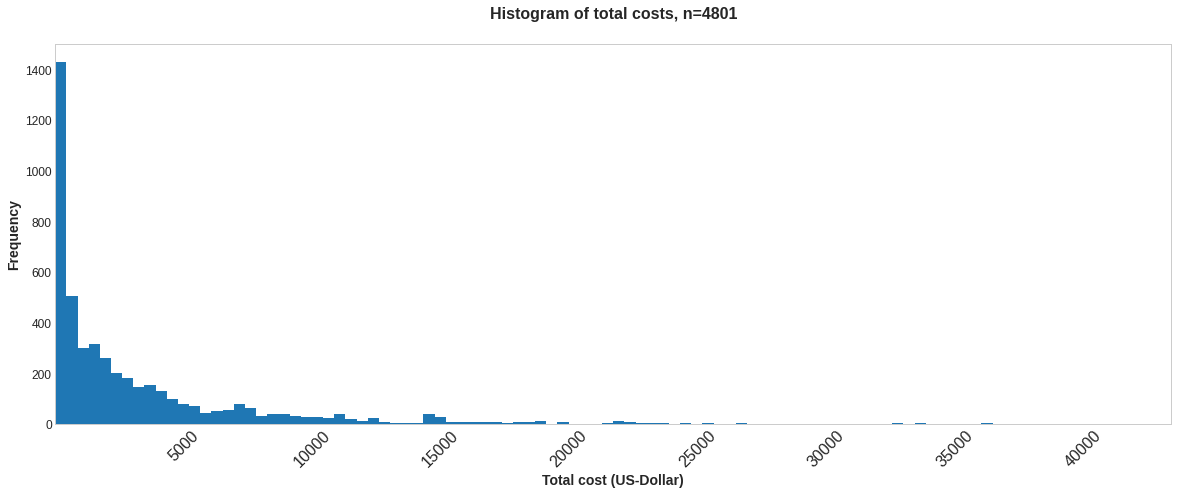

In [355]:
#create histogram with 100 bins 
data['total_cost'].hist(bins=100, figsize=(20,7));
plt.title('Histogram of total costs, n='+str(len(data)), 
          fontweight ="bold", fontsize = "16"); 

#label axis
plt.xlabel('Total cost (US-Dollar)', weight='bold');
plt.ylabel('Frequency',  weight='bold');
plt.xticks(fontsize=16, rotation = 45);

#increase space between title and plot
ax = plt.gca();
ttl = ax.title
_ = ttl.set_position([.5, 1.05]);

#hide grid lines and neglect margin on x-axis
plt.grid(False);
plt.margins(x=0);

#plot chart
plt.show(); 

**Interpretation**

We see that the majority of tourists spends less than `5,000 US-Dollars` and that there is long-tail distribution with total costs up to `35,000 US-Dollars`.
For the following charts, we differentiate by length of the trip, socio-demographic differences and travel purpose to better understand the distribution of the response variable and identify trends.

In [341]:
#create correlation matrix for response variable total_cost
corr_matrix = data.corr()
corr_matrix['total_cost'].sort_values(ascending=False)

total_cost        1.000000
total_female      0.276352
total_male        0.185951
night_zanzibar    0.146839
night_mainland    0.020953
Name: total_cost, dtype: float64

**2. Total costs by number of travel partner**

The two columns, `total_female` and `total_male`, reveil an interesting information about the dataset. It might be that one record **does not represent** the `total_cost` of **one tourist**. Moreover, it could represent the cost related to the survey participant and his/her travel partners together. We combine the two columns `total_female` and `total_male` to get the `number of travel partner` and plot them against `total_cost`.

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Total costs by number of people, n=4120')

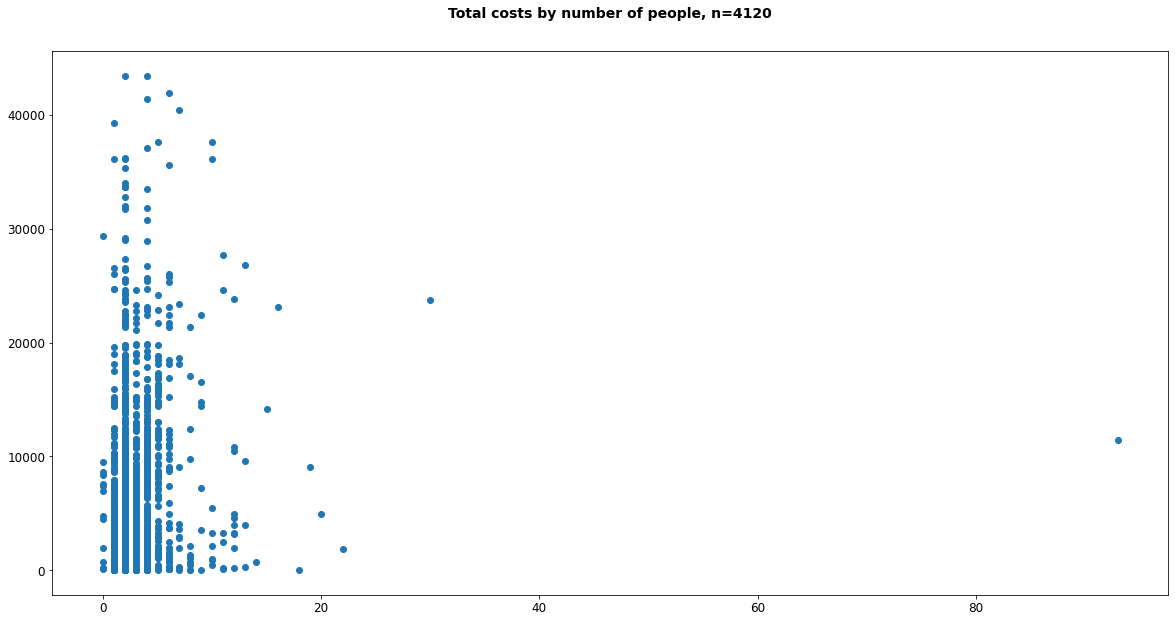

In [457]:
#assign columns to variables
x = data['total_female'] + data['total_male']
y = data['total_cost']

#setup chart    
plt.figure(figsize = (20, 10));
plt.scatter(x, y);
plt.title('Total costs by number of people, n='+str(len(data)), weight='bold', fontsize='14');

#increase space between title and plot
ax = plt.gca(); 
ttl = ax.title
ttl.set_position([.5, 1.05]);

#hide grid lines
plt.grid(False);

#plot chart
plt.show()   

**Interpretation**

The result looks counter-inuitively and there is no clear linear relationship noticeable. Furthermore, the correlation matrix below shows rather a weak than a strong relationship.
We use the columns `night_mainland` and `night_zanzibar` to take the `length of stay` into consideration.

We split the plots into several subplots, whereby each subplot represents a particular `length of stay` (e.g. 1 day). The `x-axis` represents `number of travel partners` and `y-axis` the `total_cost`. We limit the plot to the days, in which we have a lot of density, namely days `0` to day `15`.

**3. Total costs by number of travel partners and length of stay**

<Figure size 1296x720 with 0 Axes>

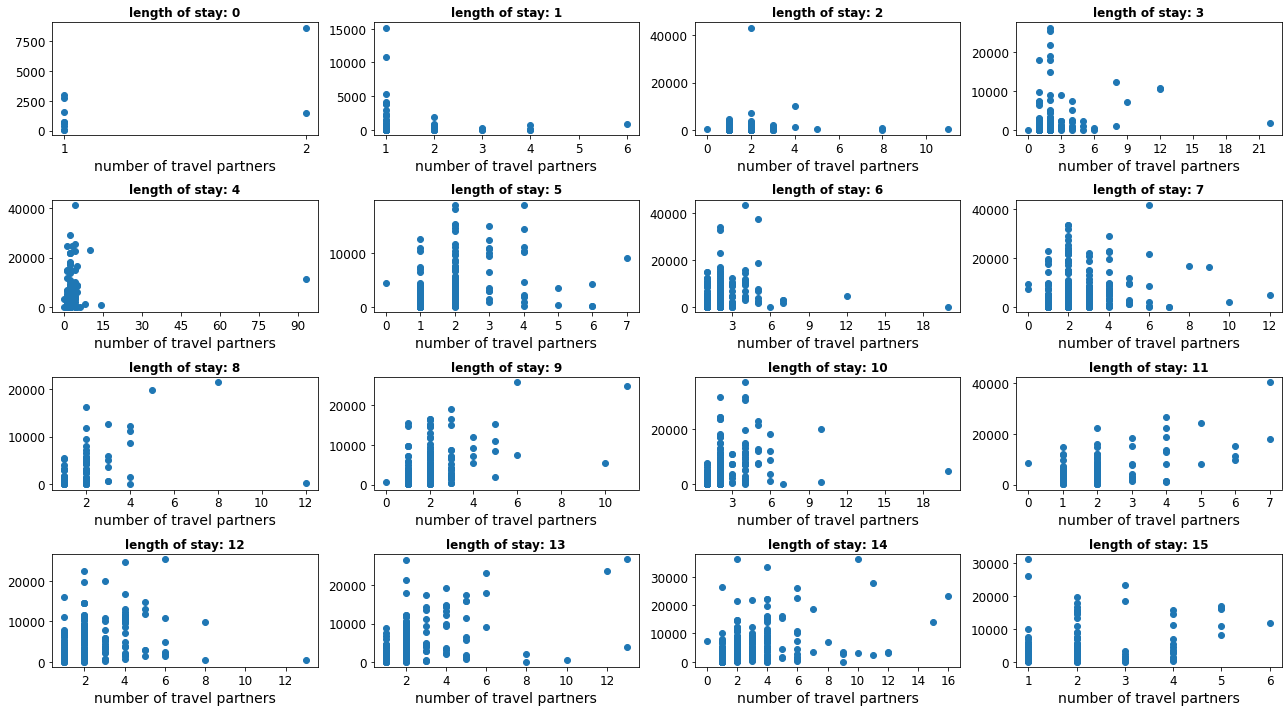

In [447]:
#create df copy only for visualization purposes
df_copy = data;

#create new column to get total stay length
df_copy['stay_length'] = df_copy['night_mainland'] + df_copy['night_zanzibar'];
df_copy['stay_length'] = df_copy['stay_length'].astype(int);
df_copy['total_male'] = df_copy['total_male'].astype(int);
df_copy['total_female'] = df_copy['total_female'].astype(int);

#create subplot categories
stay_length = [i for i in range(0,16)];

plt.figure(figsize = (18, 10));

for d in stay_length:
    x = df_copy[df_copy['stay_length'] == d]['total_female'] + df_copy[df_copy['stay_length'] == d]['total_male'];
    y = df_copy[df_copy['stay_length'] == d]['total_cost'];
    _ = plt.subplot(4, 4, d + 1);
    _ = plt.plot(x, y, 'o');
    _ = plt.title('length of stay: ' +str(d), weight='bold');
    _ = plt.xlabel('number of travel partners');
    _ = plt.tight_layout()

    #increase distance between title and plot
    ax = plt.gca();
    ttl = ax.title;
    ttl.set_position([.5, 1.05]);
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(False)



**Interpretation**

Even though differentiating between the `length of stay`, the plots keep showing a weak relationship between `number of travel partners` and `total cost` and a lot of noise remains. It is not possible to say conclusively how the `total_cost` is related to one record in the data set. More detailed information from the publisher is not available. However, given the weak correlation, we assume that `total_cost` **relates to the survery participant and his/her travel partners.**

**4. Number of tourists by country**

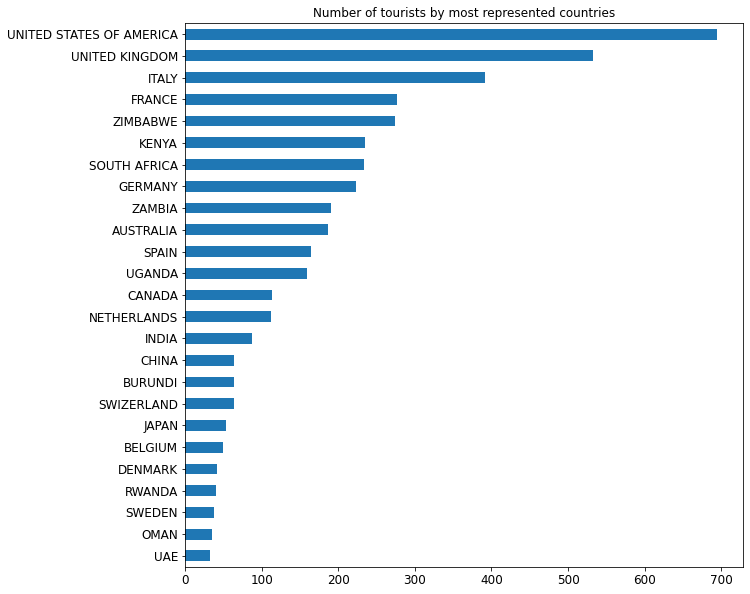

In [454]:
#calculate how many times each country appears
score = [country for country in data['country'].value_counts()]

#get corresponding country name for each score
country = [country for country in data['country'].value_counts().index]

#plot results by showing the 25 most represented countries
tourists_by_country = pd.Series(score, index=country)
tourists_by_country.nlargest(25).sort_values().plot(kind='barh', title ='Number of tourists by most represented countries',
                                                    figsize = (10, 10));

**Interpretation**

Countries are not distributed equally with a strong centralisation around a very few dominant countries followed by a `long-tail distribution`. The calculation below states how many times countries appear `less than 10 times`. 
This insight will be considered when it comes to splitting the data as an unbalanced data set can lead to biased results.

In [453]:
#identify countries appear less than 10 times
counts = data['country'].value_counts()
less_than_10 = data.loc[data['country'].isin(counts.index[counts < 10])]

#calculate how many countries appear less than 10 times
print('Number of countries that appear less than 10 times:', len(less_than_10['country'].unique()))

#calculate how many rows are affected
print('Number of rows affected:', len(less_than_10))

Number of countries that appear less than 10 times: 64
Number of rows affected: 178


**5. Average total cost by country**

We only consider countries that appear more `than 50 times` to avoid bias (e.g. very high total cost by one tourist whose country only occurs once).

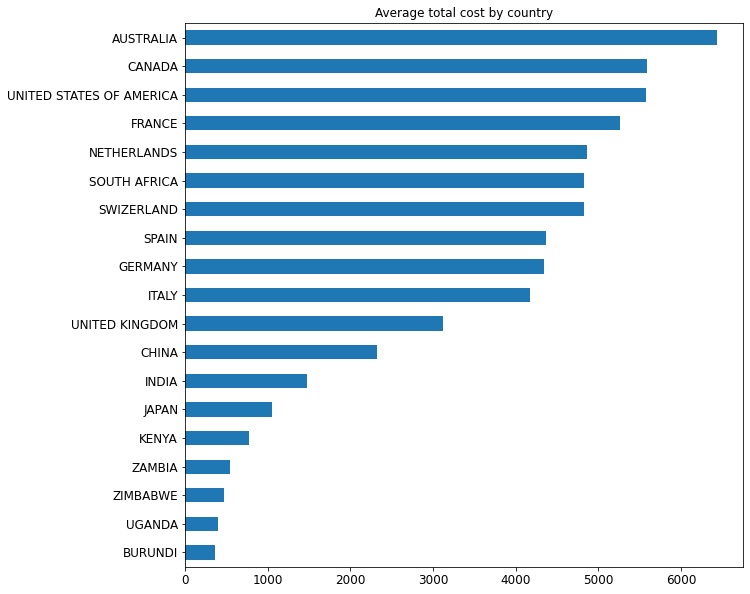

In [455]:
#identify countries that appear more than 50 times
counts = data['country'].value_counts()
data = data.loc[data['country'].isin(counts.index[counts > 50])]

#calculate avg total cost per country that appears more than 50 times
country = [country for country in data.groupby('country')['total_cost'].mean().index]
avg_total_cost = [country for country in data.groupby('country')['total_cost'].mean()]

#plot results by showing the top 25 countries
avg_cost_by_country = pd.Series(avg_total_cost, index=country)
avg_cost_by_country.nlargest(20).sort_values().plot(kind='barh', title ='Average total cost by country',
                                                    figsize = (10, 10));

**Interpretation**

The `average total costs` by the top countries resonate with their corresponding purchase power. Furthermore, since there is already a wide gap between the top countries noticable (e.g. Burundi with < 1,000 vs. Australia with > 6,000 US-Dollar), this attribute can play a crucial role in terms of feature importance. 

## 4. Data preperation for model training

**Feature creation**

We introduce `number of people` (number of travel partners) and `number of nights` (length of stay) as new features since this aggregation makes interpretation more convenient and also reduces the number of features.

In [320]:
#create new columns for new features
data['number_of_people'] = data['total_female'] + data['total_male']
data['number_of_nights'] = data['night_mainland'] + data['night_zanzibar']

In [321]:
#drop predecessor columns
data.drop(columns=['total_male', 'total_female', 'night_mainland', 'night_zanzibar'], inplace = True)

**Stratified sampling**

Countries which occur less than 100 times will be neglected due to the potential issue raised in the data exploration part. We apply stratified sampling based on `country` to avoid a highly unbalanced dataset.

In [322]:
#drop countries that occur less than 100 times
counts = data['country'].value_counts()
data = data.loc[data['country'].isin(counts.index[counts > 100])]

In [323]:
#add categorical column to country column
data['country_num'] = pd.Categorical(data['country'])
data['country_num'] = data.country_num.cat.codes

In [324]:
#select response variable
x = data.drop(columns=['total_cost'], axis=1) 
y = data['total_cost'].copy()

In [325]:
#stratified sampling on country column
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=data[['country_num']])

In [326]:
#drop country_num column
data.drop(columns=['country_num'], inplace = True)
x.drop(columns=['country_num'], inplace = True)
x_train.drop(columns=['country_num'], inplace = True)
x_test.drop(columns=['country_num'], inplace = True)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [327]:
#split numerical and categorical columns
data_num = x.select_dtypes(include=[np.number])
data_cat = x.select_dtypes(include=[np.object])

#create data pipeline
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs), 
    ])

#transform x_train - only transform() for test data as we use the scaling paramaters learned on the train data
x_train = full_pipeline.fit_transform(x_train)
x_test = full_pipeline.transform(x_test)

#check shape
x_train.shape
x_test.shape

(3030, 80)

(758, 80)

## 5. Select and train models

**Evaluation metrics**

We consider `mean absolute error (MAE)`, `root mean square error (RMSE)`, and `R2` as our metrics of choice since we face a regression problem.

**Models**

We focus on the models until chapter 5 of the lecture book which are `linear regression`, `polynomial regression` combined with `regularisation` techniques and `SVM regression`.

**Create function to better output scores**

In [14]:
#create function to evaluate model performance on train and test data
def evaluate(model, features, labels):
    '''
    Input trained model, features of the train (test) set and train (test) labels.
    Compute MAE, RMSE and R2 score and assign to corresponding list.
    Print MAE, RMSE and R2 score.
    '''
    #compute predictions
    predictions = model.predict(features)
    
    #calculate mean absolute percentage error (MAPE)
    errors = abs(predictions - labels)
    mape = np.mean(100 * (errors / labels))
    accuracy = 100 - mape
    
    #calculate rmse
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    
    #calculate mae
    mae = mean_absolute_error(labels, predictions)
    
    #calculate r2 score and convert into percentage format
    r2 = r2_score(labels, predictions) * 100

    print('Model Performance:')
    print('MAE: {:0.2f}'.format(mae))
    print('RMSE: {:0.2f}'.format(rmse))
    print('R2:', round(r2, 2), '%')

### 5a. Linear regression

**Model setup**

In [369]:
#create linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

**Evaluation**

In [370]:
#evaluate on train data
evaluate(lin_reg, x_train, y_train)

#evaluate on test data
evaluate(lin_reg, x_test, y_test)

Model Performance:
MAE: 2665.60
RMSE: 4326.73
R2: 39.35 %
Model Performance:
MAE: 2670.61
RMSE: 4425.04
R2: 31.58 %


**Feature importance**

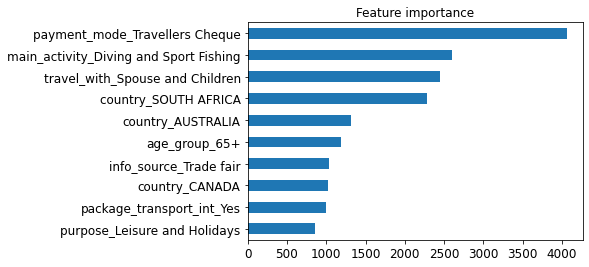

In [410]:
#assign back attribute names to encoded features
cat_encoder = full_pipeline.named_transformers_['cat']
cat_hot_attribs = list(cat_encoder.categories_)
cat_one_hot_attribs = [str(cat_attribs[index]) + '_' + category for index,categories in enumerate(cat_hot_attribs) for category in categories]
attributes = num_attribs + cat_one_hot_attribs

#compute feature importance
coefficients = lin_reg.coef_
feature_importance = sorted(zip(coefficients, attributes), reverse=True)
weight, attribute = zip(*feature_importance)

#plot feature importance
feat_importances = pd.Series(weight, index=attribute)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title ='Feature importance');

**Interpretation**

The simple regression model can moderately fit the data. `RMSE` is relatively high considering that most tourists spend between 1,000 and 15,000 US-Dollars. This also shows that the data does not follow a strict linear problem.

### 5b. Polynomial regression

We introduce polynominal features to the linear regression model to better capture the non-linearity of data. We train the model with an initial range of up to `4 degrees`. We avoid using cross-validation on the train data since the large size of new columns caused by polynomial features will make it very computational expensive (see formula `(n+d)!/d!n!` where `n` is the number of observations and `d` the degree). Consequently, the performance is always directly compared with the test data to spot overfitting problems. 

In [422]:
#create list to collect every RMSE score for plotting them later
rmse_train = []
rmse_test = []

#initial degrees to be used
degrees = [1, 2, 3, 4] 

for degree in degrees:
    #create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    
    #fit data
    x_train_poly = poly_features.fit_transform(x_train)
    x_test_poly = poly_features.transform(x_test)
    
    #create linear regression model and fit
    poly_reg = LinearRegression()
    poly_reg.fit(x_train_poly, y_train)
       
    #store model locally
    pkl_filename = 'poly_regression_model_degree_' + str(degree) + '.pkl'  

    with open(pkl_filename, 'wb') as file:  
        pickle.dump(poly_reg, file)
    
    #evaluate on train and test data
    print('-----------------------------------')
    print('Degree of polynomial regression: %d' %degree)
    print('Train evaluation')
    evaluate(poly_reg, x_train_poly, y_train)
    print('---------------')
    print('Test evaluation')
    evaluate(poly_reg, x_test_poly, y_test)
    
    #compute predictions for visualisation
    train_predictions = poly_reg.predict(x_train_poly)
    test_predictions = poly_reg.predict(x_test_poly)
    
    #collect rmse scores for visualisation
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predictions)))

LinearRegression()

-----------------------------------
Degree of polynomial regression: 1
Train evaluation
Model Performance:
MAE: 2665.60
RMSE: 4326.73
R2: 39.35 %
---------------
Test evaluation
Model Performance:
MAE: 2670.61
RMSE: 4425.04
R2: 31.58 %


LinearRegression()

-----------------------------------
Degree of polynomial regression: 2
Train evaluation
Model Performance:
MAE: 1776.13
RMSE: 2871.83
R2: 73.28 %
---------------
Test evaluation
Model Performance:
MAE: 5630.56
RMSE: 11592.46
R2: -369.58 %


LinearRegression()

-----------------------------------
Degree of polynomial regression: 3
Train evaluation
Model Performance:
MAE: 91.90
RMSE: 659.37
R2: 98.59 %
---------------
Test evaluation
Model Performance:
MAE: 40750.13
RMSE: 116733.40
R2: -47515.49 %


LinearRegression()

-----------------------------------
Degree of polynomial regression: 4
Train evaluation
Model Performance:
MAE: 151.77
RMSE: 707.18
R2: 98.38 %
---------------
Test evaluation
Model Performance:
MAE: 11327.64
RMSE: 67646.04
R2: -15889.79 %


**Interpretation**

The `3-degree` model scores optimal values, `MAE: 91.90`, `RMSE: 659.37`, `R2: 98.59%`. Interestingly, in the `4-degree` model, the scores already start to get worse. This might indicate that the model is already too complex even for the train data.
However, high-degree models are also prone to overfitting due to their many parameters that try to precisely fit the train data. This is shown in evaluation scores from the test data.

### 5c. Polynomial regression with regularisation

We use regularisation to anticipate the overfitting problems. We apply both `ridge` and `lasso` regression that scored best on train data, which is the 3-degree model. We use a `small range` of reasonable `regularisation weights`, $\alpha$, to not overheat the computation. However, if the optimal weight lies at the `boundary` of the range, we will expand the range to obtain an even more optimised $\alpha$ value.

Again, we evaluate the trained model directly against the test data to avoid computational expensive cross-validation runs on a high-degree model.

**Ridge regression**

In [465]:
#create list to collect every RMSE score for plotting
rmse_train = []
rmse_test = []

#create list of alpha values for regularisation weight
alpha_values = [i for i in range(1, 550, 25)]

#create polynomial features
poly_features = PolynomialFeatures(degree=3)
    
#fit data
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.transform(x_test)


for alpha in alpha_values:
    
    #create ridge regression with corresponding alpha value
    poly_ridge = Ridge(alpha=alpha)
    poly_ridge.fit(x_train_poly, y_train)
        
    #store model locally
    pkl_filename = 'poly_ridge_regression_model_degree_3_' + str(alpha) + '.pkl'  

    with open(pkl_filename, 'wb') as file:  
        pickle.dump(poly_ridge, file)
    
    #evaluate on train and test data
    print('-----------------------------------')
    print('Train evaluation')
    evaluate(poly_ridge, x_train_poly, y_train)
    print('Test evaluation')
    evaluate(poly_ridge, x_test_poly, y_test)
    
    #compute prediction for visualisation
    train_predictions = poly_ridge.predict(x_train_poly)
    test_predictions = poly_ridge.predict(x_test_poly)
    
    #collect RMSE score for visualisation
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predictions)))

Ridge(alpha=1)

-----------------------------------
Train evaluation
Model Performance:
MAE: 316.76
RMSE: 1042.04
R2: 96.48 %
Test evaluation
Model Performance:
MAE: 4570.44
RMSE: 7921.66
R2: -119.28 %


Ridge(alpha=26)

-----------------------------------
Train evaluation
Model Performance:
MAE: 993.21
RMSE: 1883.27
R2: 88.51 %
Test evaluation
Model Performance:
MAE: 3088.10
RMSE: 5423.42
R2: -2.78 %


Ridge(alpha=51)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1185.27
RMSE: 2152.07
R2: 85.0 %
Test evaluation
Model Performance:
MAE: 2911.44
RMSE: 5147.58
R2: 7.41 %


Ridge(alpha=76)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1297.64
RMSE: 2317.92
R2: 82.59 %
Test evaluation
Model Performance:
MAE: 2816.94
RMSE: 4996.78
R2: 12.76 %


Ridge(alpha=101)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1375.03
RMSE: 2437.39
R2: 80.75 %
Test evaluation
Model Performance:
MAE: 2756.82
RMSE: 4899.17
R2: 16.13 %


Ridge(alpha=126)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1433.65
RMSE: 2530.31
R2: 79.26 %
Test evaluation
Model Performance:
MAE: 2713.29
RMSE: 4829.76
R2: 18.49 %


Ridge(alpha=151)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1480.40
RMSE: 2606.06
R2: 78.0 %
Test evaluation
Model Performance:
MAE: 2680.64
RMSE: 4777.09
R2: 20.26 %


Ridge(alpha=176)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1518.73
RMSE: 2669.81
R2: 76.91 %
Test evaluation
Model Performance:
MAE: 2652.64
RMSE: 4736.18
R2: 21.62 %


Ridge(alpha=201)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1551.28
RMSE: 2724.71
R2: 75.95 %
Test evaluation
Model Performance:
MAE: 2629.18
RMSE: 4703.43
R2: 22.7 %


Ridge(alpha=226)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1579.20
RMSE: 2772.82
R2: 75.09 %
Test evaluation
Model Performance:
MAE: 2608.16
RMSE: 4676.20
R2: 23.59 %


Ridge(alpha=251)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1603.58
RMSE: 2815.57
R2: 74.32 %
Test evaluation
Model Performance:
MAE: 2590.22
RMSE: 4653.34
R2: 24.34 %


Ridge(alpha=276)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1625.28
RMSE: 2853.99
R2: 73.61 %
Test evaluation
Model Performance:
MAE: 2573.24
RMSE: 4633.19
R2: 24.99 %


Ridge(alpha=301)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1644.73
RMSE: 2888.83
R2: 72.96 %
Test evaluation
Model Performance:
MAE: 2558.39
RMSE: 4615.85
R2: 25.55 %


Ridge(alpha=326)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1662.35
RMSE: 2920.66
R2: 72.36 %
Test evaluation
Model Performance:
MAE: 2544.71
RMSE: 4600.24
R2: 26.05 %


Ridge(alpha=351)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1678.60
RMSE: 2949.93
R2: 71.81 %
Test evaluation
Model Performance:
MAE: 2532.44
RMSE: 4586.62
R2: 26.49 %


Ridge(alpha=376)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1693.35
RMSE: 2977.02
R2: 71.29 %
Test evaluation
Model Performance:
MAE: 2521.35
RMSE: 4574.24
R2: 26.89 %


Ridge(alpha=401)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1706.98
RMSE: 3002.19
R2: 70.8 %
Test evaluation
Model Performance:
MAE: 2510.53
RMSE: 4562.31
R2: 27.27 %


Ridge(alpha=426)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1719.41
RMSE: 3025.69
R2: 70.34 %
Test evaluation
Model Performance:
MAE: 2500.79
RMSE: 4551.80
R2: 27.6 %


Ridge(alpha=451)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1731.00
RMSE: 3047.70
R2: 69.91 %
Test evaluation
Model Performance:
MAE: 2492.03
RMSE: 4542.14
R2: 27.91 %


Ridge(alpha=476)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1741.56
RMSE: 3068.41
R2: 69.5 %
Test evaluation
Model Performance:
MAE: 2484.59
RMSE: 4533.52
R2: 28.18 %


Ridge(alpha=501)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1751.76
RMSE: 3087.94
R2: 69.11 %
Test evaluation
Model Performance:
MAE: 2477.58
RMSE: 4525.19
R2: 28.45 %


Ridge(alpha=526)

-----------------------------------
Train evaluation
Model Performance:
MAE: 1761.13
RMSE: 3106.40
R2: 68.74 %
Test evaluation
Model Performance:
MAE: 2471.32
RMSE: 4517.13
R2: 28.7 %


In [368]:
#feature importance
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_)
attributes = [category for categories in cat_one_hot_attribs for category in categories]

78

**Visualised results**

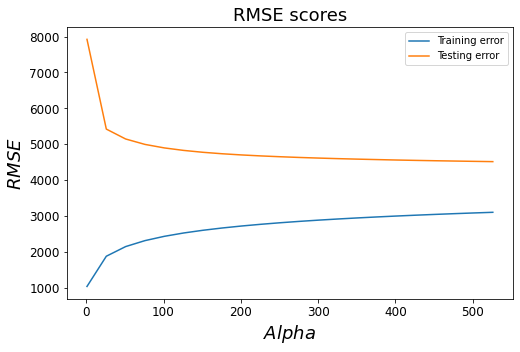

In [466]:
#plot RMSE scores against corresponding alpha value
fig, ax = plt.subplots(figsize = (8,5));
ax.plot(alpha_values, rmse_train, label="Training error");
ax.plot(alpha_values, rmse_test, label="Testing error");
plt.xlabel("$Alpha$", fontsize=18);
plt.ylabel("$RMSE$", fontsize=18);
plt.title("RMSE scores", fontsize=18);
ax.legend();
plt.show();

**Interpretation**

As $\alpha$ increases, the test `testing error` (RMSE score) decreases drastically, which shows that the regularisation works. Furthermore, the plot shows that the `testing error` reaches a plateaus after a certain $\alpha$ value. After this point, a larger $\alpha$ does not improve the `testing error`. Simultaneously, the `training error` increases for every larger $\alpha$ value, which means the model gains bias and start to underfit. The calculation below identifies the optimal $\alpha$ value and shows the corresponding testing error. Feature importance is also shown.

In [473]:
#identify index of smallest RMSE score
min_rmse_test = np.array(np.where(rmse_test == min(rmse_test)))

#identify optimal alpha value by using previous index position
optimal_alpha = alpha_values[int(min_rmse_test)]
print('Optimal alpha value: %d' %optimal_alpha)
print('Best RMSE score on test data: %d' %min(rmse_test))

Optimal alpha value: 526
Best RMSE score on test data: 4517


**Feature importance**

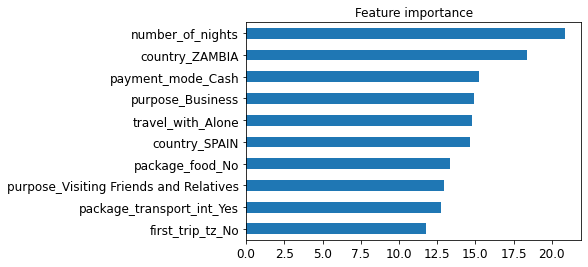

In [493]:
#load best model
filename = 'poly_ridge_regression_model_degree_3_'+str(526)+'.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

#feature importance
coefficients = loaded_model.coef_
feature_importance = sorted(zip(coefficients, attributes), reverse=True)
weight, attribute = zip(*feature_importance)

#plot feature importance
feat_importances = pd.Series(weight, index=attribute)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title ='Feature importance');

**Lasso regression**

In [476]:
#create list to collect every RMSE score for plotting
rmse_train = []
rmse_test = []

#create list of alpha values for regularisation weight
alpha_values = [i for i in range(1, 250, 25)]

#create polynomial features
poly_features = PolynomialFeatures(degree=3)
    
#fit data
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.transform(x_test)


for alpha in alpha_values:
    
    #create laso regression with corresponding alpha value
    poly_lasso = Lasso(alpha=alpha)
    poly_lasso.fit(x_train_poly, y_train)
    
    train_predictions = poly_lasso.predict(x_train_poly)
    test_predictions = poly_lasso.predict(x_test_poly)
    
    #store model locally
    pkl_filename = 'poly_lasso_regression_model_degree_3_' + str(round(alpha, 5)) + '.pkl'  

    with open(pkl_filename, 'wb') as file:  
        pickle.dump(poly_lasso, file)
    
    #evaluate on train and test data
    print('-----------------------------------')
    print('Train evaluation')
    evaluate(poly_lasso, x_train_poly, y_train)
    print('Test evaluation')
    evaluate(poly_lasso, x_test_poly, y_test)
    
    #compute predictions for visualisation
    train_predictions = poly_lasso.predict(x_train_poly)
    test_predictions = poly_lasso.predict(x_test_poly)
    
    #collect rmse scores into list
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predictions)))

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7843971296.690764, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=1)

-----------------------------------
Train evaluation
Model Performance:
MAE: 846.04
RMSE: 1548.48
R2: 92.23 %
Test evaluation
Model Performance:
MAE: 3538.69
RMSE: 6365.97
R2: -41.61 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24382200123.785812, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=26)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2085.52
RMSE: 3722.78
R2: 55.1 %
Test evaluation
Model Performance:
MAE: 2416.67
RMSE: 4661.76
R2: 24.06 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27126979116.325188, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=51)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2207.25
RMSE: 3969.02
R2: 48.96 %
Test evaluation
Model Performance:
MAE: 2371.58
RMSE: 4452.48
R2: 30.73 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28845317764.330666, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=76)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2278.32
RMSE: 4080.13
R2: 46.07 %
Test evaluation
Model Performance:
MAE: 2363.98
RMSE: 4375.68
R2: 33.1 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29914250370.814346, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=101)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2351.07
RMSE: 4185.42
R2: 43.25 %
Test evaluation
Model Performance:
MAE: 2388.83
RMSE: 4365.86
R2: 33.4 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30706074607.14062, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=126)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2417.67
RMSE: 4272.50
R2: 40.86 %
Test evaluation
Model Performance:
MAE: 2424.58
RMSE: 4373.72
R2: 33.16 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31048264717.99693, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=151)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2474.61
RMSE: 4342.38
R2: 38.91 %
Test evaluation
Model Performance:
MAE: 2460.63
RMSE: 4395.16
R2: 32.5 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31059858538.96495, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=176)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2513.63
RMSE: 4381.05
R2: 37.82 %
Test evaluation
Model Performance:
MAE: 2496.40
RMSE: 4411.17
R2: 32.01 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30786348426.175262, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=201)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2554.70
RMSE: 4420.13
R2: 36.7 %
Test evaluation
Model Performance:
MAE: 2537.29
RMSE: 4435.34
R2: 31.26 %


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:512: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30152536559.925323, tolerance: 9352382.06166533
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=226)

-----------------------------------
Train evaluation
Model Performance:
MAE: 2594.35
RMSE: 4454.94
R2: 35.7 %
Test evaluation
Model Performance:
MAE: 2575.92
RMSE: 4461.79
R2: 30.44 %


**Visualised results**

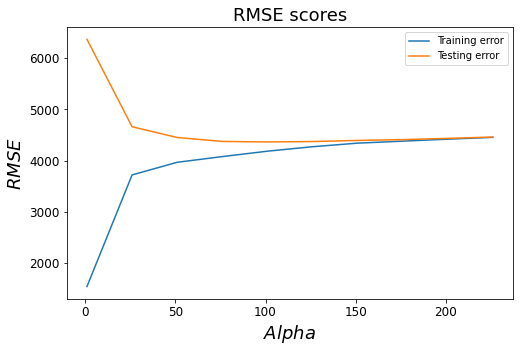

In [477]:
#create visualisation 
fig, ax = plt.subplots(figsize = (8,5));
ax.plot(alpha_values, rmse_train, label="Training error");
ax.plot(alpha_values, rmse_test, label="Testing error");
plt.xlabel("$Alpha$", fontsize=18);
plt.ylabel("$RMSE$", fontsize=18);
plt.title("RMSE scores", fontsize=18);
ax.legend();
plt.show();

**Interpretation**

The lasso regression shows a very similar behaviour compared to the ridge regression. The testing error starts to decrease meaning that the regularisation works and reaches the plateau in the middle of the $\alpha$ range. The calculation below identifies the optimal $\alpha$ value and shows the corresponding testing error. Since lasso regression is able to shrink coefficients to zero, we also evaluate how many coefficients got penalised that much. Feature importance is also shown in the end.

In [484]:
#identify index of smallest RMSE score
min_rmse_test = np.array(np.where(rmse_test == min(rmse_test)))

#identify optimal alpha value by using previous index position
optimal_alpha = alpha_values[int(min_rmse_test)]
print('Optimal alpha value: %d' %optimal_alpha)
print('Best RMSE score on test data: %d' %min(rmse_test))

Optimal alpha value: 101
Best RMSE score on test data: 4365


In [489]:
#count how many coefficients are shrunken to zero
count = 0
for i in loaded_model.coef_:
    if i == 0:
        count += 1

print('Number of coefficients shrunken to zero: %d' %count)
print('Percentage of coefficients shrunken to zero: {:0.2f}' .format(count/len(loaded_model.coef_)))

Number of coefficients shrunken to zero: 1299251
Percentage of coefficients shrunken to zero: 0.67


**Feature importance**

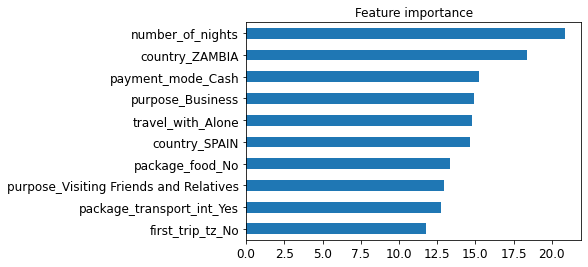

In [485]:
#load best model
filename = 'poly_lasso_regression_model_degree_3_'+str(optimal_alpha)+'.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

#feature importance
coefficients = loaded_model.coef_
feature_importance = sorted(zip(coefficients, attributes), reverse=True)
weight, attribute = zip(*feature_importance)

#plot feature importance
feat_importances = pd.Series(weight, index=attribute)
feat_importances.nlargest(10).sort_values().plot(kind='barh', title ='Feature importance');

### 5d. SVM Regression

SVM offers more parameters than the previous models to optimise hyperparameter. Available parameters:

- **Degree**: number of the degree for the polynomial model
- **Epsilon**: margin of error
- **C**: regularisation weight 

We neglect `random` or `grid search` since the variety of parameters is not that large. For finding the optimal degree, we use the range around 3 since those can be reasonable degrees given previous polynomial calculations and treat `C` as a constant. After this, we find the optimal value for `C` by using the identified degree from the previous calculation. For every iteration, we set the margin error $\epsilon$ to `0.5`.

**Note:** the strength of the regularisation is inversely proportional to C.

**Find optimal polynomial degree**

In [533]:
#create list to collect every RMSE score for plotting
rmse_train = []
rmse_test = []

#initial degrees to be used
degrees = [2, 3, 4, 5]

for degree in degrees:

    #create svm regression model
    svm = SVR(kernel='poly', degree=degree, C=100, epsilon=0.5);
    svm.fit(x_train, y_train);
    
    #store model locally
    pkl_filename = 'svm_regression_model_degree_' + str(degree) + '.pkl' 

    with open(pkl_filename, 'wb') as file:  
            pickle.dump(svm, file)
        
    #evaluate on train and test data
    print('-----------------------------------')
    print('Train evaluation')
    evaluate(svm, x_train, y_train)
    print('Test evaluation')
    evaluate(svm, x_test, y_test)
    
    #compute predictions for visualisation
    train_predictions = svm.predict(x_train)
    test_predictions = svm.predict(x_test)
    
    #collect rmse scores into list
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predictions)))

SVR(C=100, degree=2, epsilon=0.5, kernel='poly')

-----------------------------------
Train evaluation
Model Performance:
MAE: 2259.62
RMSE: 4593.17
R2: 31.65 %
Test evaluation
Model Performance:
MAE: 2173.69
RMSE: 4448.75
R2: 30.84 %


SVR(C=100, epsilon=0.5, kernel='poly')

-----------------------------------
Train evaluation
Model Performance:
MAE: 2206.17
RMSE: 4543.48
R2: 33.12 %
Test evaluation
Model Performance:
MAE: 2158.53
RMSE: 4426.94
R2: 31.52 %


SVR(C=100, degree=4, epsilon=0.5, kernel='poly')

-----------------------------------
Train evaluation
Model Performance:
MAE: 2162.84
RMSE: 4519.99
R2: 33.81 %
Test evaluation
Model Performance:
MAE: 2143.87
RMSE: 4404.30
R2: 32.22 %


SVR(C=100, degree=5, epsilon=0.5, kernel='poly')

-----------------------------------
Train evaluation
Model Performance:
MAE: 2119.53
RMSE: 4490.33
R2: 34.68 %
Test evaluation
Model Performance:
MAE: 2145.87
RMSE: 4412.32
R2: 31.97 %


In [534]:
#identify index of smallest RMSE score on test data
min_rmse_test = np.array(np.where(rmse_test == min(rmse_test)))

#identify optimal degree by using previous index position
optimal_degree = degrees[int(min_rmse_test)]
print('Optimal degree: %d' %optimal_degree)

Optimal degree: 4


**Find optimal C-value**

In [538]:
#create list to collect every RMSE score for plotting
rmse_train = []
rmse_test = []

#create values for regularisation weight
c_values = [x for x in range(1,1000,50)]

for C in c_values:
    
    #create svm regression model
    svm = SVR(kernel='poly', degree=4, C=C, epsilon=0.5);
    svm.fit(x_train, y_train);
    
    #store model locally
    pkl_filename = 'svm_regression_model_degree_4_' + str(C) + '.pkl' 

    with open(pkl_filename, 'wb') as file:  
        pickle.dump(svm, file)
    
    #compute predictions for visualisation
    train_predictions = svm.predict(x_train);
    test_predictions = svm.predict(x_test);
    
    #collect rmse scores into list
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, test_predictions)))

SVR(C=1, degree=4, epsilon=0.5, kernel='poly')

SVR(C=51, degree=4, epsilon=0.5, kernel='poly')

SVR(C=101, degree=4, epsilon=0.5, kernel='poly')

SVR(C=151, degree=4, epsilon=0.5, kernel='poly')

SVR(C=201, degree=4, epsilon=0.5, kernel='poly')

SVR(C=251, degree=4, epsilon=0.5, kernel='poly')

SVR(C=301, degree=4, epsilon=0.5, kernel='poly')

SVR(C=351, degree=4, epsilon=0.5, kernel='poly')

SVR(C=401, degree=4, epsilon=0.5, kernel='poly')

SVR(C=451, degree=4, epsilon=0.5, kernel='poly')

SVR(C=501, degree=4, epsilon=0.5, kernel='poly')

SVR(C=551, degree=4, epsilon=0.5, kernel='poly')

SVR(C=601, degree=4, epsilon=0.5, kernel='poly')

SVR(C=651, degree=4, epsilon=0.5, kernel='poly')

SVR(C=701, degree=4, epsilon=0.5, kernel='poly')

SVR(C=751, degree=4, epsilon=0.5, kernel='poly')

SVR(C=801, degree=4, epsilon=0.5, kernel='poly')

SVR(C=851, degree=4, epsilon=0.5, kernel='poly')

SVR(C=901, degree=4, epsilon=0.5, kernel='poly')

SVR(C=951, degree=4, epsilon=0.5, kernel='poly')

**Visualised results**

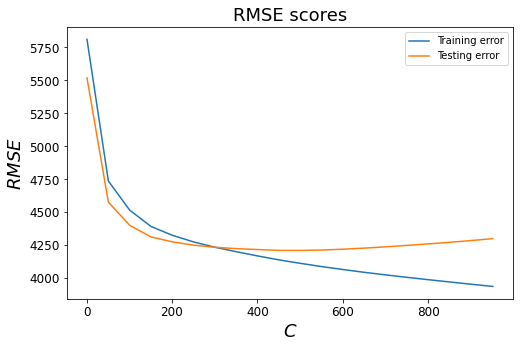

In [539]:
#create visualisation 
fig, ax = plt.subplots(figsize = (8,5));
ax.plot(c_values, rmse_train, label="Training error");
ax.plot(c_values, rmse_test, label="Testing error");
plt.xlabel("$C$", fontsize=18);
plt.ylabel("$RMSE$", fontsize=18);
plt.title("RMSE scores", fontsize=18);
ax.legend();
plt.show();

**Interpretation**

Both the training and testing error decrease drastically in the beginning by increasing the `C` value. This is because the reduction in variance is larger than the addition of a bias. After a certain degree, the testing error reaches the plateau, on which the optimal `C`-value lies. The calculation below identifies the optimal value and shows the corresponding testing error. The training error keeps to fall. **However, it is important here to know that the strength of the regularisation is inversely proportional to C.** Coefficients for feature importance cannot be shown since they are only available when using a linear kernel. 

In [537]:
#identify index of smallest RMSE score
min_rmse_test = np.array(np.where(rmse_test == min(rmse_test)))

#identify optimal C by using previous index position
optimal_c = c_values[int(min_rmse_test)]
print('Optimal regularisation weight (C): %d' %optimal_c)
print('Best RMSE score on test data: %d' %min(rmse_test))

Optimal regularisation weight (C): 501
Best RMSE score on test data: 4210


## 6. Conclusion

All used models have achieved certain prediction power. The simple linear regression model was considered to be the base model given the nature to only fit a strict linear line. However, higher-degree model did not really improve the prediction power. The polynomial regression models have shown to fit the train data very well even though only using a few degrees. However, running them on test set showed their extreme overfitting problem. Introducing regularised models with `ridge` and `lasso regression` techniques helped to reduce the variance for a certrain degree, but reveiled underfitting problems. In the case of the ridge regression, it even scored a worse score than the linear model. The SVM regression model did improve the performance only marginally.

**Models:**
1. Linear regression model: 4425 RMSE score
2. Best ridge regression model: 4517 RMSE score
3. Best lasso regression model: 4365 RMSE score
4. Best SVM regression model: 4219 RMSE score

Considering a possible value range most likely between `1,000` and `15,000 US-Dollars` for `total_cost`, the scores of the shortlisted models are not very satisfying. Models of this nature could be rather applied to run a forecast trends with certain margin, instead of accurate predictions that are used for cost-expensive decision making.

Furthermore, the results also show that these rather simple models are not sufficient enough to explain the entire noisiness of the underlying data set. Escpecially, considering the small datasize compared to the number of encoded attributes in this case, it is very tricky to build reliable models based on the simple model stack provided up to chapter 5. Besides appyling more sophisticated models, collecting more `historical data points` or getting new attributes, such as `season time` can also be very helpful to improve the models used in this work. 